<a href="https://colab.research.google.com/github/sjtae/data_science_project/blob/main/project01/Python_Project/hotel_bookings_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import our dataset
df = pd.read_csv("hotel_bookings.csv")

In [3]:
# our hotel dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74108 entries, 0 to 74107
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           74108 non-null  object 
 1   is_canceled                     74108 non-null  int64  
 2   lead_time                       74108 non-null  int64  
 3   arrival_date_year               74108 non-null  int64  
 4   arrival_date_month              74108 non-null  object 
 5   arrival_date_week_number        74108 non-null  int64  
 6   arrival_date_day_of_month       74108 non-null  int64  
 7   stays_in_weekend_nights         74108 non-null  int64  
 8   stays_in_week_nights            74108 non-null  int64  
 9   adults                          74108 non-null  int64  
 10  children                        74104 non-null  float64
 11  babies                          74108 non-null  int64  
 12  meal                            

## Feature engineering

In [4]:
# create 'total_guests' column to sum all the guests in one room
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['total_guests'] = df['total_guests'].fillna(0).astype(int)

In [5]:
# create 'total_length' column to find the total nights the guests stayed at the hotel
df['total_length'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

In [6]:
# create 'room_change' column to determine if the reserved room is different from the assigned room
df['room_change'] = df['reserved_room_type'] == df['assigned_room_type']

In [7]:
# create 'early_bird' column to see the numbers of reservations made more than 6 months in advance
df['early_bird'] = df['days_in_waiting_list'] > 180
df['early_bird']

0        False
1        False
2        False
3        False
4        False
         ...  
74103    False
74104    False
74105    False
74106    False
74107    False
Name: early_bird, Length: 74108, dtype: bool

### Combine our dataset with weather data

In [8]:
month_name_to_number = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

# Create new year, month, day column to easily convert to datetime type
df['month'] = df['arrival_date_month'].map(month_name_to_number)
df['year'] = df['arrival_date_year'].astype(str)
df['day'] = df['arrival_date_day_of_month'].astype(str)

# Create 'datetime' column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
df['datetime']


0       2015-07-01
1       2015-07-01
2       2015-07-01
3       2015-07-01
4       2015-07-01
           ...    
74103   2015-09-10
74104   2015-09-10
74105   2015-09-10
74106   2015-09-10
74107   2015-09-10
Name: datetime, Length: 74108, dtype: datetime64[ns]

In [9]:
# Load weather data for City Hotel(located in Lisbon, Portugal) with specific columns
columns_to_select = ['datetime', 'temp', 'tempmin', 'tempmax','precip','preciptype', 'conditions', 'description']
weather_city_hotel = pd.read_csv('lisbon_2015-07-27_2017-08-31.csv', usecols=columns_to_select)
weather_city_hotel['datetime'] = pd.to_datetime(weather_city_hotel['datetime'])

# Load weather data for Resort Hotel(located in Faro, Portugal) with specific columns
columns_to_select = ['datetime', 'temp', 'tempmin', 'tempmax','precip','preciptype', 'conditions', 'description']
weather_resort_hotel = pd.read_csv('faro_2015-07-27_2017-08-31.csv', usecols=columns_to_select)
weather_resort_hotel['datetime'] = pd.to_datetime(weather_resort_hotel['datetime'])

# Merge city hotel data with selected weather columns
hotel_city_hotel = df[df['hotel'] == 'City Hotel']
merged_city_hotel = pd.merge(hotel_city_hotel, weather_city_hotel, on='datetime', how='inner')

# Merge resort hotel data with selected weather columns
hotel_resort_hotel = df[df['hotel'] == 'Resort Hotel']
merged_resort_hotel = pd.merge(hotel_resort_hotel, weather_resort_hotel, on='datetime', how='inner')

# Concatenate the results into a single DataFrame
merged_df_weather = pd.concat([merged_city_hotel, merged_resort_hotel])
merged_df_weather['preciptype'] = merged_df_weather['preciptype'].fillna('no_precip')
merged_df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72384 entries, 0 to 38912
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           72384 non-null  object        
 1   is_canceled                     72384 non-null  int64         
 2   lead_time                       72384 non-null  int64         
 3   arrival_date_year               72384 non-null  int64         
 4   arrival_date_month              72384 non-null  object        
 5   arrival_date_week_number        72384 non-null  int64         
 6   arrival_date_day_of_month       72384 non-null  int64         
 7   stays_in_weekend_nights         72384 non-null  int64         
 8   stays_in_week_nights            72384 non-null  int64         
 9   adults                          72384 non-null  int64         
 10  children                        72380 non-null  float64       
 11  ba

## Seasonal Booking Analysis

### Number of bookings by month & week

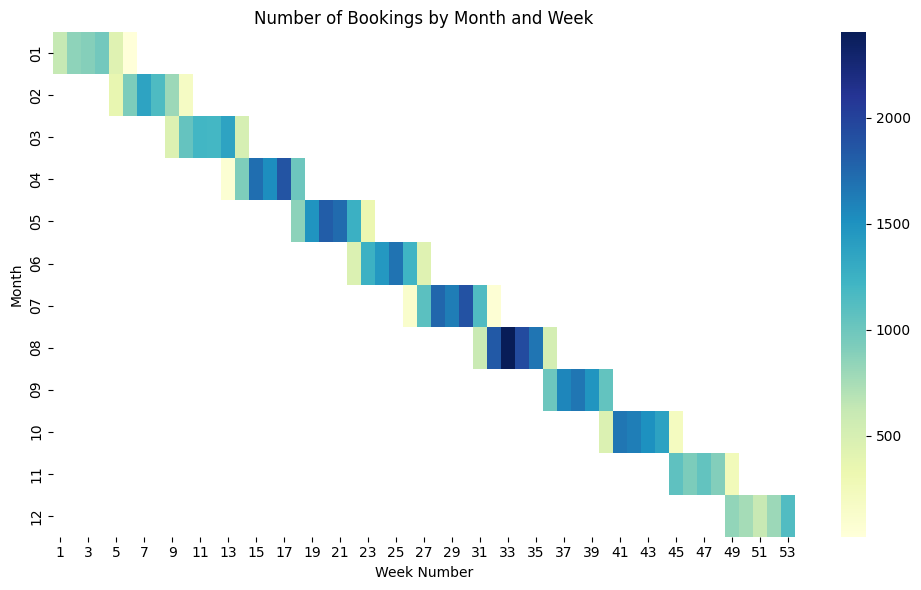

In [31]:
# find the number of bookings group by month and week
bookings_by_month_and_week = df.groupby(['month', 'arrival_date_week_number']).size().reset_index(name='number_of_bookings')

# Pivot the data to create a pivot table
pivot_table = bookings_by_month_and_week.pivot(index='month', columns='arrival_date_week_number', values='number_of_bookings')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=False, cmap='YlGnBu')
plt.xlabel('Week Number')
plt.ylabel('Month')
plt.title('Number of Bookings by Month and Week')
plt.tight_layout()
plt.show()

### How many nights people booking in week days?

In [54]:
bookings_by_weekday = df.groupby(['stays_in_week_nights']).size().reset_index(name='number_of_bookings')
bookings_by_weekday.sort_values(by='number_of_bookings', ascending=False, ignore_index=True).head(5)

,stays_in_week_nights,number_of_bookings
0,2,19960
1,1,16868
2,3,13322
3,5,9209
4,4,6115


### What is the best weather conditions to make people stay at the hotel?

In [53]:
bookings_by_weather_conditions = merged_df_weather.groupby(['conditions', 'description']).size().reset_index(name='number_of_bookings')
bookings_by_weather_conditions.sort_values(by='number_of_bookings', ascending=False, ignore_index=True).head(5)

,conditions,description,number_of_bookings
0,Partially cloudy,Partly cloudy throughout the day.,29277
1,Clear,Clear conditions throughout the day.,20483
2,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,4586
3,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,4484
4,Partially cloudy,Clearing in the afternoon.,3490


### What is the factors that influence cancelations?

In [60]:
# Calculate the correlation coefficients for is_calceled column
correlations = merged_df_weather.corr()['is_canceled'].drop('is_canceled')

# Sort the correlations in descending order to identify factors that influence cancellations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Print the sorted correlations
print(correlations_sorted.head(3))

<ipython-input-60-0110522203cc>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_df_weather.corr()['is_canceled'].drop('is_canceled')


agent                          0.385415
room_change                    0.348187
required_car_parking_spaces    0.303638
Name: is_canceled, dtype: float64


#### Correlation Summary
##### - The involvement of an agent in bookings has a positive correlation (0.385) with cancellations. This suggests that bookings made through agents may be more likely to result in cancellations.

##### - Room changes are also positively correlated (0.348) with cancellations. This implies that guests who experience room changes may have a higher likelihood of canceling their reservations.

##### - The requirement for car parking spaces shows a positive correlation (0.304) with cancellations. This indicates that guests who request car parking spaces in their bookings may be more prone to cancel.